<a href="https://colab.research.google.com/github/isayahc/2600_books/blob/main/Copy_of_%5BAugust_2024%5D_Genspace_Spidroin_Protein_Phylogeny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genspace Summer of Spiders: Phylogenetics

**PLEASE MAKE A COPY OF THIS GOOGLE COLABORATORY & EDIT YOUR COPY**

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.8 MB/s eta 0:00:00


In [ ]:
!apt-get install clustalo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libargtable2-0
The following NEW packages will be installed:
  clustalo libargtable2-0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 273 kB of archives.
After this operation, 694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libargtable2-0 amd64 13-1.1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalo amd64 1.2.4-7 [259 kB]
Fetched 273 kB in 1s (401 kB/s)
Selecting previously unselected package libargtable2-0.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../libargtable2-0_13-1.1_amd64.deb ...
Unpacking libargtable2-0 (13-1.1) ...
Selecting previously unselected package clustalo.
Preparing to unpack .../clustalo_1.2.4-7_amd64.deb ...
Unpacking clustalo (1.2.4-7) ...
Setting up

In [ ]:
import pandas as pd
from Bio import SeqIO, Entrez
import requests
from io import BytesIO, StringIO
import sys
from Bio.Align.Applications import ClustalOmegaCommandline
import time

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


# Spidroin Sequences
*Choose subset of spidroin sequences (nucleotides, not amino acids). Many common phylogenetic algorithms are optimized for using nucleotide sequences.*

One approach is to focus on a particular mechanical property e.g.:
- Tensile strength
- Crystallinity

Using this approach, we could take a few directions:

**Option 1**: Filter the spidroin sequences for that particular mechanical property

**Option 2**: Sample spidroin sequences (at least 25 species, no more than 500) to capture a sufficient diversity of species with different mechanical properties and see how these species relate to each other in a phylogenetic tree.
**--> Makes most sense to start with Option 2**.


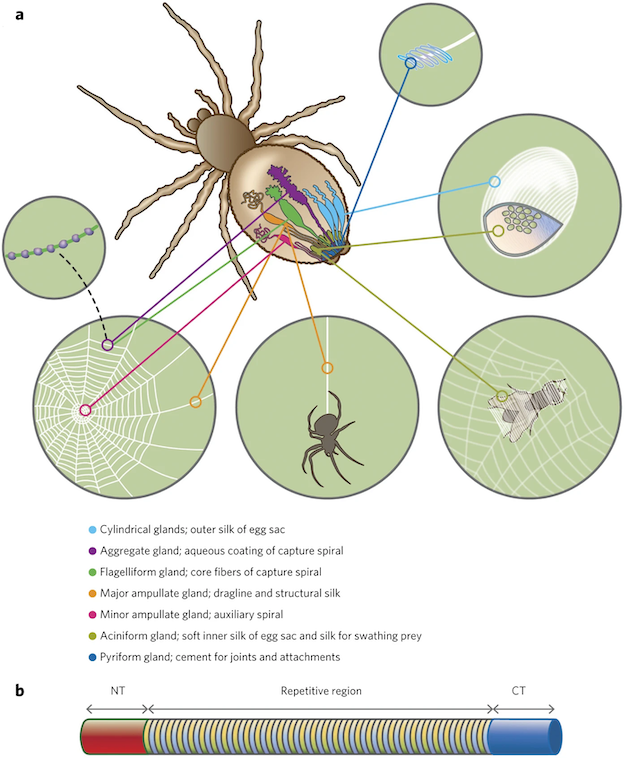

Source: Rising & Johansson 2015. Toward spinning artificial spider silk. Nature Chemical Biology. https://doi.org/10.1038/nchembio.1789

# Outline for Constructing Phylogenetic Tree from FASTA File

## Read sequences from the FASTA file

Until we have the set of spidroin nucleotide sequences that we want to use, use the Spidroin nucleotide fasta file found on the [Spider Silkome Database "About Us" page](https://spider-silkome.org/about) (Download section)
- Download file and upload to Colab

In [ ]:
fasta_file_id = '1gjGEqCMdSM_PoHT2ZZ9X0vtRbuBt6-eU'
fasta_download_url = f'https://drive.google.com/uc?export=download&id={fasta_file_id}'

In [ ]:
response = requests.get(fasta_download_url)

if response.status_code != 200:
    print("Failed to download the fasta file. Exiting.")
    sys.exit(1)

fasta_file_content = StringIO(response.content.decode('utf-8'))
sequences = list(SeqIO.parse(fasta_file_content, "fasta"))

### Check format of sequences

ID: id1 | id2 | family | genus | species | silk protein | silk protein | region of silk protein

e.g.
ID: 11131|4790|Tetragnathidae|Leucauge|celebesiana|MaSp2|MaSp2|NTD

Sequence: ATGAGTTTCACTTCTCGGCTTGCGTTGAGCTTTTTGGTTTTGTTCTGCACTCAGAGCATGTTTGCTCTGGGTCAGG....

Sequence length: 1251

In [ ]:
num_sequences = len(sequences)
print(f"# spidroin protein sequences: {num_sequences}")

# spidroin protein sequences: 11155


In [ ]:
# print last 25 spidroin protein sequences to see syntax (contains NTD)
for seq_record in sequences[-25:]:
    print(f"ID: {seq_record.id}")
    print(f"Sequence: {seq_record.seq}")
    print(f"Sequence length: {len(seq_record.seq)}\n")

ID: 11131|4790|Tetragnathidae|Leucauge|celebesiana|MaSp2|MaSp2|NTD
Sequence: ATGAGTTTCACTTCTCGGCTTGCGTTGAGCTTTTTGGTTTTGTTCTGCACTCAGAGCATGTTTGCTCTGGGTCAGGCAAATAGCCCTTGGTCAAACACTCAAACAGCAGAAGCTTTTATTCGCAGTTTCTTAGGTGCTGCAGCACAAAGCGGAGCTTTCAATGCCGACCAAATGGATGATATGTCGACCATCGGTGATACATTGATGGGAGCAATGGAGAAGATGGCTCGAAGCAATAAGAGCTCGAAATCCAAGCTGCAAGCACTCAACATGGCCTTTGCATCCTCCGTGGCAGAAATTGCTGTGGCAGATGGGGGAGCTGCAAATATTGCAGCACCAACAAGCGCCATTGCAGATGCTCTCAGCTCAGCATTCTTACAAGTTACTGGAGCTGTCAATTATCAGTTCGTCAACGAAATCAAAAGCTTGATTACGATGTTTGCTCAAAATAATGCAAACCAAGTGTCATACGGAGGCTCTTCAGGAGGAGGCGGAGGAGGGTCAGCAGCAGCTGCAGACAGTGCATCTGCCGGAGGTGGATACGGACCAGGACCCCAAGGACCATCTGGCCCTGGACCCCAAGGACCTTCCGGACCCGGACCCCAAGGACCCTCTTCATATAGTAGCGTGTCAGTGACTTCATACGGACCCGGACCTCAAGCACCTTCTGGACCCCAAGGACCTTCCGGACCCCAAGGACCCTCTTCCTACAGTAGCGTATCAGTGTCTTCATACGGACCTGGGCCCCAAGGACCTTCTGGATCTGGACCCCAAGGTCCTTCTGGACCCGGACCCCAAGGACCATACGGACCTGGTCCCCAAAGACCATCCGGACCTGGTCCTCAAGGACCATCTGGACCTGGACCCCAAGGGCCTTCAGGACCTGGACCCCAAGGACAGTCTTCATACAGTAGCAGCGTATC

### Proof of Concept: choose 100 sequences to align (and subsequently build a tree)
The .fasta file provided on the Spider Silkome Database website has 11,155 spidroin sequences. It could take several hours for. Additionally, constructing and interpreting a tree for that many sequences is possible but can present challenges. Even visualizing it can be impractical.


**Choose specific spidroin protein**
It can be interesting to filter the sequences for a specific type of spidroin protein, e.g. Major Ampullate Spidroin 1 (MaSp1) and then build the phylogeny for a set of MaSp1 proteins different species.


Let's explore filtering for a specific spidroin protein, choosing 100 of them across different spider species, and building the phylogeny.

**MaSp1**
- MaSp1 is a primary component of dragline silk, and its properties of strength and elasticity make it interesting to study.
- Its protein structure is characterized by repeating motifs that form beta-sheet crystals interspersed with amorphous regions.
- Studying MaSp1 can reveal how this critical protein has evolved across different species, providing insights into the adaptive strategies of spiders.
- By examining MaSp1 across diverse species, you can investigate evolutionary pressures, gene duplications, and functional divergences that have occurred over time.
- Understanding the evolutionary nuances of MaSp1 can inform the development of synthetic silk with tailored properties for industrial applications.

**TODO**: give what options are available for spidroin proteins in .fasta file, NTD, CTD, etc. Either people can do research ahead of time

In [ ]:
spidroin_protein_filter = "MaSp1|MaSp1|NTD"
num_sequences_for_phylogeny = 100

In [ ]:
filtered_sequences = [
    seq_record for seq_record in sequences if spidroin_protein_filter in seq_record.id
]
print(f"# {spidroin_protein_filter} sequences: {len(filtered_sequences)}")

# MaSp1|MaSp1|NTD sequences: 479


In [ ]:
selected_sequences = []
filtered_species = set()
selected_species = set()

for seq_record in filtered_sequences:
    parts = seq_record.id.split("|")
    if len(parts) >= 5:
        species_name = f"{parts[2]} {parts[3]} {parts[4]}"
        filtered_species.add(species_name)

        # select up to num_sequences_for_phylogeny from different species
        if species_name not in selected_species and len(selected_sequences) < num_sequences_for_phylogeny:
            selected_sequences.append(seq_record)
            selected_species.add(species_name)


num_filtered_species = len(filtered_species)
print(f"# unique species in {spidroin_protein_filter} sequences: {num_filtered_species}")
print(f"unique species in {spidroin_protein_filter} sequences: {filtered_species}")
print(f"# selected species in {spidroin_protein_filter} sequences: {len(selected_species)}")

# unique species in MaSp1|MaSp1|NTD sequences: 222
unique species in MaSp1|MaSp1|NTD sequences: {'Theridiidae Steatoda grossa', 'Tetragnathidae Metleucauge yunohamensis', 'Theridiidae Spheropistha miyashitai', 'Pisauridae Dolomedes saganus', 'Araneidae Cyrtophora exanthematica', 'Theridiidae Rhomphaea hyrcana', 'Araneidae Eustala cepina', 'Tetragnathidae Tetragnatha makiharai', 'Theridiidae Anelosimus iwawakiensis', 'Lycosidae Pardosa yaginumai', 'Tetragnathidae Tylorida striata', 'Araneidae Araneus ventricosus', 'Lycosidae Pardosa laura', 'Lycosidae Pardosa nojimai', 'Araneidae Plebs sachalinensis', 'Lycosidae Tigrosa aspersa', 'Theridiidae Moneta mirabilis', 'Pisauridae Dolomedes horishanus', 'Tetragnathidae Diphya okumae', 'Araneidae Cyrtophora ikomosanensis', 'Theridiidae Episinus kitazawai', 'Araneidae Araneus ishisawai', 'Araneidae Cyrtarachne nagasakiensis', 'Tetragnathidae Pachygnatha clercki', 'Araneidae Araneus mitificus', 'Lycosidae Xerolycosa nemoralis', 'Lycosidae Arctosa 

### Selected sequences from different species

In [ ]:
print(f"\nSelected {spidroin_protein_filter} sequences from {num_sequences_for_phylogeny} different species:")
for seq_record in selected_sequences:
    species_name = seq_record.id.split("|")[3] + " " + seq_record.id.split("|")[4]
    print(f"ID: {seq_record.id}")
    print(f"Species: {species_name}")


Selected MaSp1|MaSp1|NTD sequences from 100 different species:
ID: 11043|4542|Pisauridae|Dolomedes|sulfureus|MaSp1|MaSp1|NTD
Species: Dolomedes sulfureus
ID: 11044|769|Pisauridae|Dolomedes|angustivirgatus|MaSp1|MaSp1|NTD
Species: Dolomedes angustivirgatus
ID: 10942|102|Tetragnathidae|Leucauge|blanda|MaSp1|MaSp1|NTD
Species: Leucauge blanda
ID: 5886|4544|Araneidae|Araneus|uyemurai|MaSp1|MaSp1|NTD
Species: Araneus uyemurai
ID: 5887|1299|Theridiidae|Argyrodes|kumadai|MaSp1|MaSp1|NTD
Species: Argyrodes kumadai
ID: 5909|1283|Pisauridae|Dolomedes|pegasus|MaSp1|MaSp1|NTD
Species: Dolomedes pegasus
ID: 5910|3751|Theridiidae|Moneta|mirabilis|MaSp1|MaSp1|NTD
Species: Moneta mirabilis
ID: 5917|2600|Lycosidae|Arctosa|laminata|MaSp1|MaSp1|NTD
Species: Arctosa laminata
ID: 5948|1214|Lycosidae|Pardosa|laura|MaSp1|MaSp1|NTD
Species: Pardosa laura
ID: 5952|3586|Theridiidae|Spheropistha|miyashitai|MaSp1|MaSp1|NTD
Species: Spheropistha miyashitai
ID: 5957|6517|Pisauridae|Dolomedes|japonicus|MaSp1|MaSp1|

## Align Sequences

Aligning sequences is important for understanding evolutionary relationships and identifying conserved, functionally important regions across DNA, RNA, or proteins. It can also aid in predicting the structure and function of new or uncharacterized sequences by comparing them to known sequences.

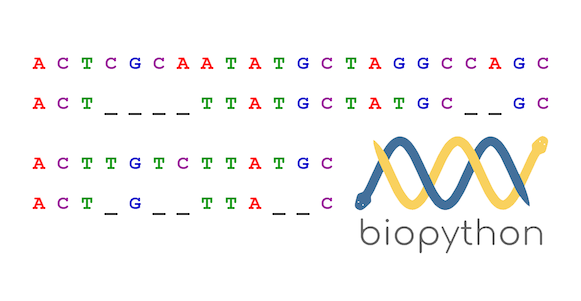

In [ ]:
# check if aligned already
aligned = all(len(seq) == len(selected_sequences[0]) for seq in selected_sequences)
aligned

False

### Align selected 100 sequences (and subsequently build a tree)
Let's align the 100 selected sequences and construct the tree (takes 5-10 minutes).

In [ ]:
# spidroin_seqs_100 = sequences[:100]
spidroin_seqs_100 = selected_sequences
aligned_seqs_100_file_path = 'aligned_seqs_100.fasta'

In [ ]:
seqs_100_fasta_file_path = 'spidroin_seqs_100.fasta'
SeqIO.write(spidroin_seqs_100, seqs_100_fasta_file_path, "fasta")

100

In [ ]:
def align_sequences(num_seqs, unaligned_seqs_file_path, aligned_seqs_file_path):
    start_time = time.time()
    # Define the path for the aligned output file

    # Perform multiple sequence alignment
    clustalomega_cline = ClustalOmegaCommandline(infile=unaligned_seqs_file_path, outfile=aligned_seqs_file_path, verbose=True, auto=True)
    stdout, stderr = clustalomega_cline()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to align {num_seqs} sequences: {elapsed_time} seconds")

In [ ]:
align_sequences(100, seqs_100_fasta_file_path, aligned_seqs_100_file_path)

Time taken to align 100 sequences: 213.98882222175598 seconds


In [ ]:
# read the aligned sequences
aligned_seqs_100 = list(SeqIO.parse(aligned_seqs_100_file_path, "fasta"))
aligned_seqs_100

[SeqRecord(seq=Seq('ATGAGTTGGATAGGGAGACTTGTCATTTT---ATTGCTTCTTGTAACTTGCCAA...---'), id='11043|4542|Pisauridae|Dolomedes|sulfureus|MaSp1|MaSp1|NTD', name='11043|4542|Pisauridae|Dolomedes|sulfureus|MaSp1|MaSp1|NTD', description='11043|4542|Pisauridae|Dolomedes|sulfureus|MaSp1|MaSp1|NTD', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGAGTTGGATAGGGAGACTTGTTATTTT---ATTGGTCCTTGTAGCTTGCCAA...---'), id='11044|769|Pisauridae|Dolomedes|angustivirgatus|MaSp1|MaSp1|NTD', name='11044|769|Pisauridae|Dolomedes|angustivirgatus|MaSp1|MaSp1|NTD', description='11044|769|Pisauridae|Dolomedes|angustivirgatus|MaSp1|MaSp1|NTD', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGAGTTTCAGTTCTCGAATTGCACTCTC---CCTTCTGGTCGTGCTCTGCACC...---'), id='10942|102|Tetragnathidae|Leucauge|blanda|MaSp1|MaSp1|NTD', name='10942|102|Tetragnathidae|Leucauge|blanda|MaSp1|MaSp1|NTD', description='10942|102|Tetragnathidae|Leucauge|blanda|MaSp1|MaSp1|NTD', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGACTTGGACAGCTCGACTTGCCCTATC---ATTGCTCGTTGTGATCTGCTCC...---'), id='

In [ ]:
# spot check the aligned sequences
for seq in aligned_seqs_100[:5]:
    print(f">{seq.id}\n{seq.seq}")

>11043|4542|Pisauridae|Dolomedes|sulfureus|MaSp1|MaSp1|NTD
ATGAGTTGGATAGGGAGACTTGTCATTTT---ATTGCTTCTTGTAACTTGCCAAAGTTCTAATTCACTAGCGCAATATGCGT---CTGCAAG---TGCGACTCCCTGGTCAAGTCCAGGAACGGCGGAGAGCTTCATGTACAATTTCCTGCAAAGTATGAATCAGCAGCCAGGGTTCACAGCTGACCAGTTAGATGACATGTCTACAATCGGAGATACCTTAATACAATCAATAAAGAGCATGGCTGCATCAGGTAAGACATCACCACATAAGCTGCAGGCACTAAACATGGCGTTTGCATCGTCCATGGCAGAAATCGCAGCAAGTGAACAAGGAGGGGGAAGCATCCAAGTGAAAACCAACGCTATCGCCAATGCCCTTTCGAGTGCATTTCTACAAACAACGGGTAGTATAAATACACAATTTATAAACGAAATAACTCAACTTGTGAGCATGTTTGCT-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Build Phylogenetic Tree

In [ ]:
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Construct using distance matrix

There are several ways to calculate the distance between sequences. The default in BioPython is identity (p-distance).

**identity (p-distance)**: simple measure of the proportion of different sites between sequences

$$ distance = 1 - \frac{\# \; \; identical \; positions}{total \; \; \# \; positions} $$

Other ways of calculating distance are:
- Jukes-Cantor (JC69): corrects for multiple subsitutions at the same time
- Kimura 2-parameter (K2P): accounts for different rates of transitions & transversions
- Tamura-Nei: extends the K2P model by incorporating variable base frequencies & different transition/transversion rates

In [ ]:
alignment_100 = AlignIO.read(aligned_seqs_100_file_path, 'fasta')

In [ ]:
# calculate the distance matrix between sequences
calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment_100)

### Construct the Phylogenetic Tree using Unweighted Pair Group Method with Arithmetic Mean (UPGMA) Method

[Overview video of UPGMA method](https://www.youtube.com/watch?v=09eD4A_HxVQ)

*In the future, we can use a more sophisticated method like maximum likelihood, but for now let's use this.


Uses a hierarchical clustering method to create a rooted tree that reflects the evolutionary relationships between a set of taxa (e.g. species, sequences).
- Additive method: assumes a constant rate of evolution (molecular clock assumption), i.e. all lineages evolve at the same rate over time. *This can be unrealistic.
- Distance based: builds tree based on a distance matrix
- Agglomerative clustering: follows a bottom-up approach where it starts with individual taxa & iteratively merges the closest pairs based on the smallest distance in the distance matrix

1. Initializes each taxon as a separate cluster
2. Calculate the distance matrix (pairwise distances between all clusters)
3. Find closest pair of clusters
4. Merge closest pair of clusters into a single cluster
5. Update distance matrix to calculate distances between new cluster and all other clusters
6. Repeat steps 3-5 until all taxa are merged into single cluster
7. Construct tree based on the merging process, with branch lengths proportional to distance in the matrix

In [ ]:
# construct the phylogenetic tree using UPGMA method
constructor = DistanceTreeConstructor()
tree = constructor.upgma(distance_matrix)

## Visualize Tree

Branch length (x-axis) represents the amount of evolutionary change. It's proportional to the number of mutations that have occurred. Calculated for UPGMA based on distance matrix.

### Using Phylo.draw (basic visualization)

In [ ]:
# update the labels to use only show the species name
# e.g. if original label is '941|7288|Araneidae|Trichonephila|clavata|Flag|Flag|CTD'
# family: Araneidae, genus: Trichonephila, species: clavata
for clade in tree.get_terminals():
    clade.name = f'{clade.name.split("|")[2]}|{clade.name.split("|")[3]}|{clade.name.split("|")[4]}'  # e.g. 'clavata' is at index 4

In [ ]:
def label_func(clade):
    if clade.is_terminal():
        return clade.name
    return None

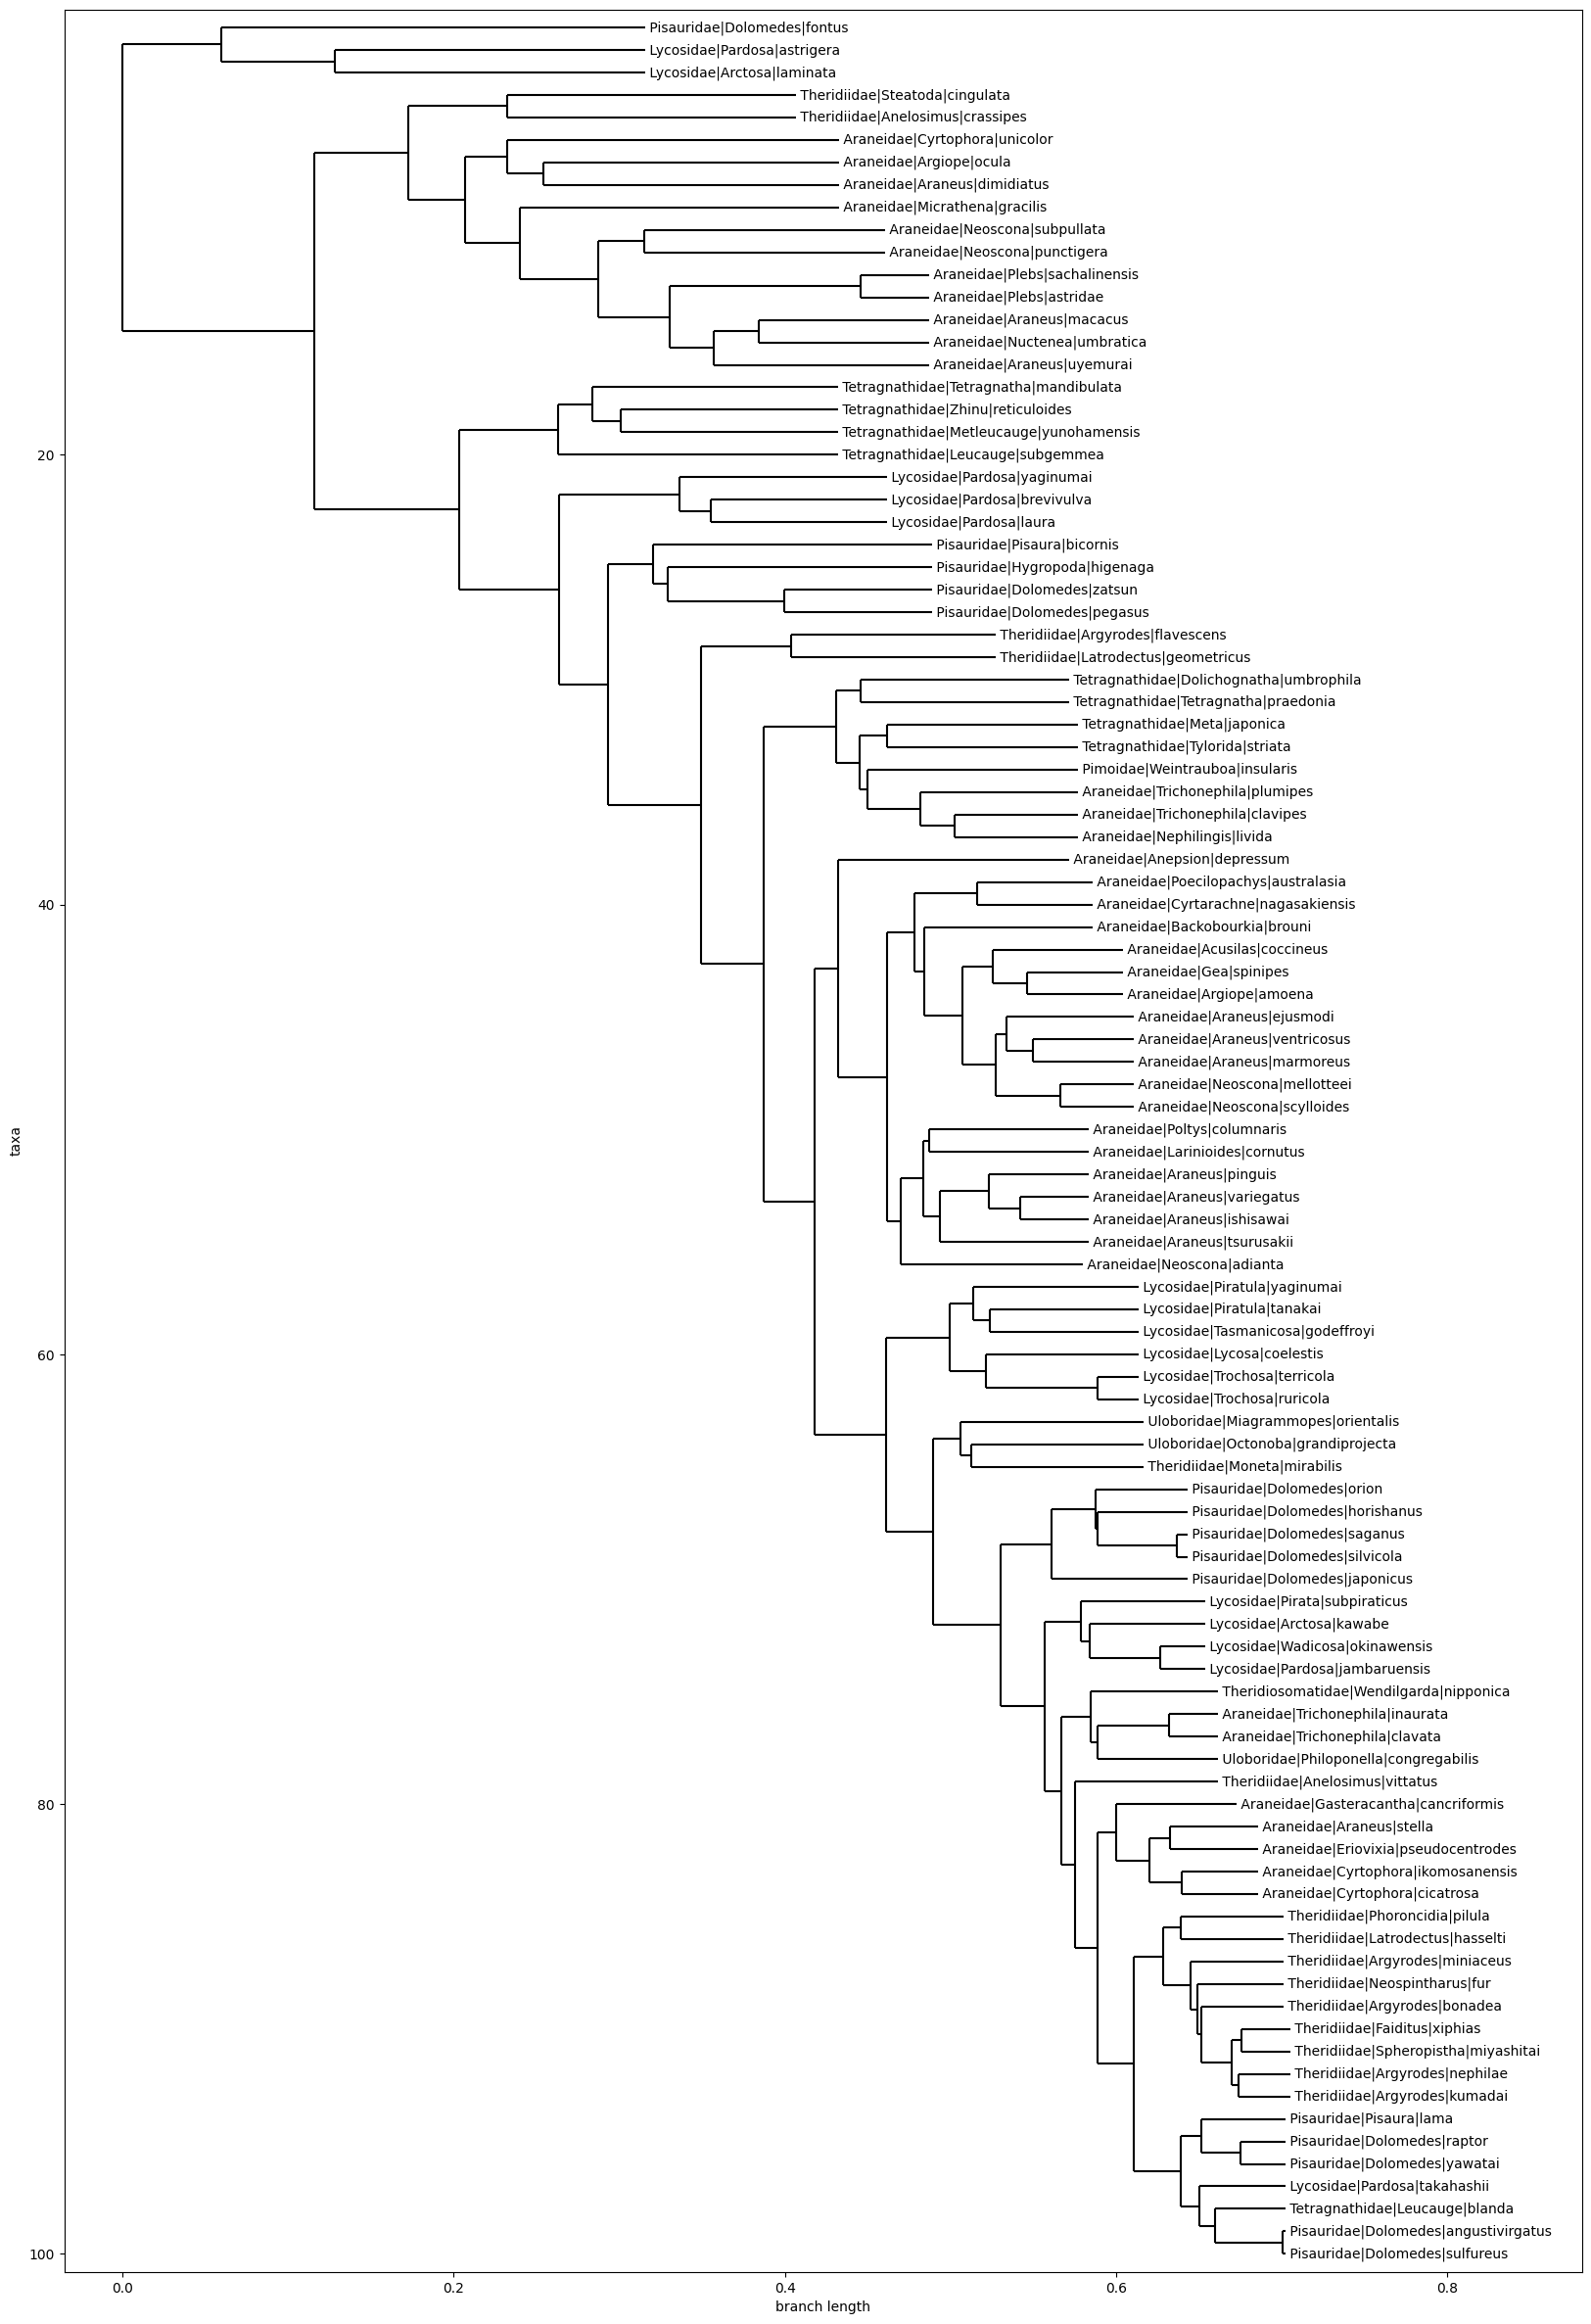

In [ ]:
fig = plt.figure(figsize=(20, 30))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, label_func=label_func)
plt.show()

# Workshop #2: Select Representative Sequences

## Interpreting the Tree

### Export Tree as `newick` file
To use with other visualization software like [iTOL](https://itol.embl.de/) (+ other tools like ete3)

In [ ]:
Phylo.write(tree, "tree.nwk", "newick")

## Select Representative Sequences
Use more sophisticated methods for choosing representative sequences for use in building the phylogenetic tree.

Here, the [scikit-learn DBSCAN clustering algorithm](https://scikit-learn.org/stable/modules/clustering.html) clusters the sequences. Then, we can choose representatives from the clusters to build the phylogenetic tree. DBSCAN does not need to know the # of clusters ahead of time (in contrast to methods like $k$-means clustering)

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

In [ ]:
# cluster sequences using DBSCAN
def cluster_sequences_dbscan(sequences, eps=0.5, min_samples=2):
    sequence_matrix = np.array(sequences)
    dbscan_instance = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan_instance.fit_predict(sequence_matrix)

    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label != -1:  # Ignore noise points
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(sequences[i])

    return clusters

In [ ]:
clusters = cluster_sequences_dbscan(example_sequences, eps=0.3, min_samples=2)
print(clusters)